In [10]:
import librosa, librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt 
%matplotlib inline

# 「MIR-02_1」音频特征小全之概览

> 在深度学习成为给音频打上标签的小能手之前，设计各种各样的音频特征（audio feature）才是音频分类或识别任务的领头军，其中充满了声学、数学建模和信号处理等技术的灵活运用，也是领会音乐技术的必修知识。

**♬ 本文为MIR音乐信息检索系列的第2.1篇文章 ♬**

**♬ 该文作为概览将与后续2.X文章共同组成音频特征小全 ♬**

概览内容包括：
- 音频特征可以从几种角度去理解？
- 根据特征的来源可以将其分为几类？
- 提取特征之前有哪些预处理工作？

---

### 『理解音频特征』

大多数音频特征起源于语音识别领域，用于理解录音中人们说了哪些话，直到九十年代末它们才被应用到音乐信息检索的任务中，逐渐也就有了更多针对于音乐音频的特征被发明出来。

☞ 大概是最久远的MIR论文之一：
Foote, Jonathan T. "Content-based retrieval of music and audio." Multimedia Storage and Archiving Systems II. Vol. 3229. International Society for Optics and Photonics, 1997.

我们的目的并不在于如何把所有特征细致地分类，而是指明可用哪些角度理解或区分开各种特征。大致上有以下四种角度：

✎ 特征的动与稳：一个特征在每段时间内都可用数值表示，随着时间轴的移动，数值大小会不断变换，那么连续多段时间内多个数值的均值/方差等就代表了该特征的动态性，但这个数值本身的物理意义是不变的，这就构成了特征“稳”的部分。

✎ 特征可覆盖的时间长短：上面提到的每段时间中的段字，即可以是音频信号加窗后得到的一帧帧，也可以是前奏/主歌/副歌等时间跨度略长的片段，因此得到的特征可以是瞬态的(instantaneous)或全局的(global)。

✎ 特征的抽象程度：越抽象，人们就越难理解，那么就对应了越底层的特征，底层特征经过处理可以变成中层的特征，比如音高、音符起始点等等，抽象程度大致等于理解乐谱里常见的音乐元素，最高层的特征则被赋予了更多语义，比如音乐的体裁等等。

✎ 特征的提取过程：在这种角度下，还能细分成以下四种过程
- 直接在音频波形上提取的特征，比如过零率(zero-crossing rate)
- 将音频进行DFT/FFT等变换后提取的特征，比如谱质心(spectral centroid)
- 需通过模型才能得到的特征，比如通过声源分离得到乐音相关的特征
- 受人耳听觉认知的启发，经过特定比例(mel或bark)过滤后得到的特征

---

### 『音频特征的类别』

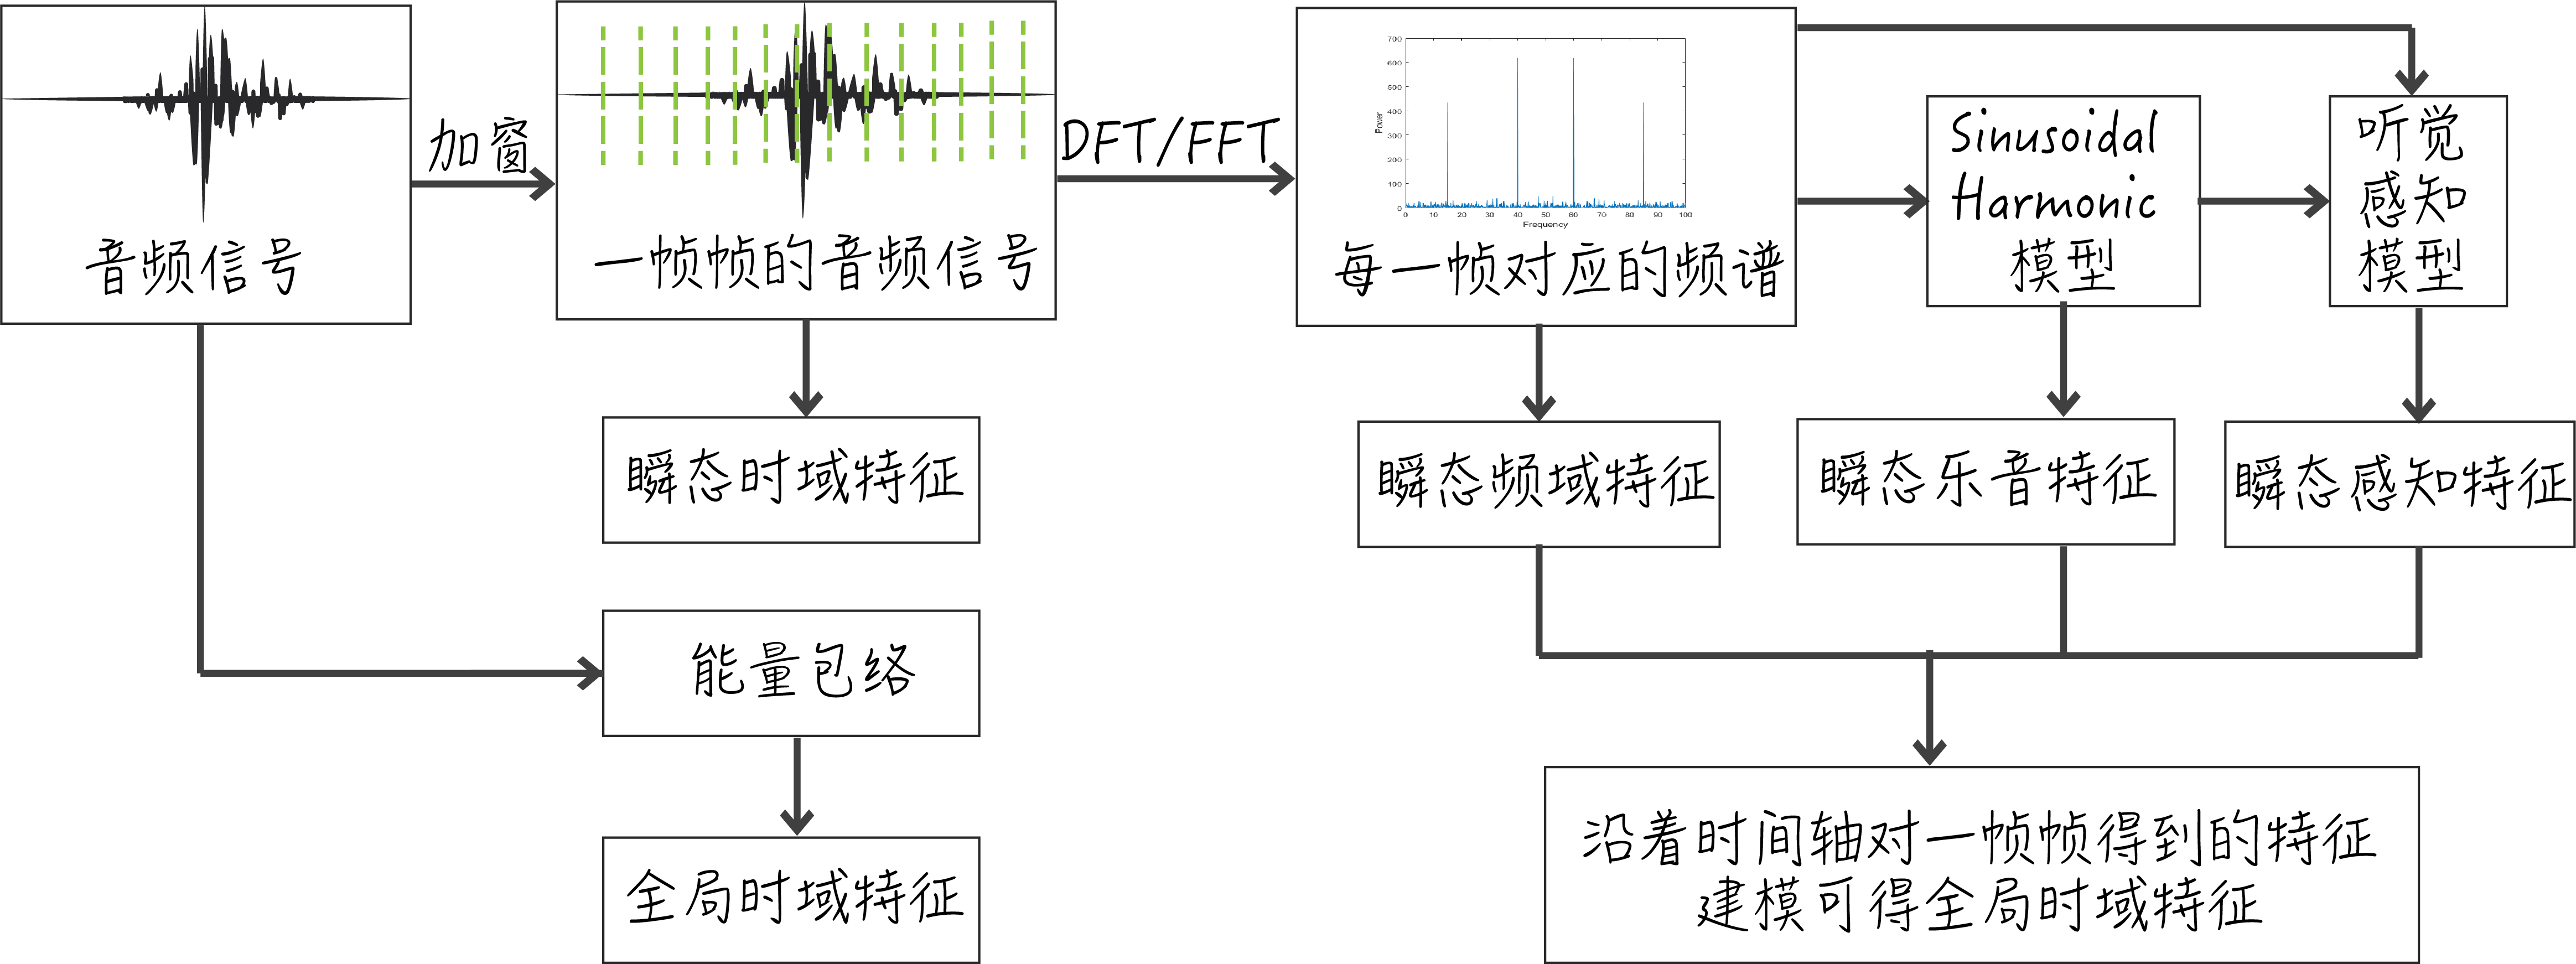

In [2]:
ipd.Image("attachment/mir02-workflow.png")

如果被上述角度绕得云里雾里的，可以参考上方图片里的各处流程中得到的不同特征，由此可将特征分为以下几大常用类别：

✎ 时域特征(temporal feature)：可从音频波形直接观察到的能量包络得出有关ADSR的特征，也可在某一帧下计算自相关系数和过零率等特征。

✎ 频域特征(spectral feature)：此类特征更更多，随意举例包括质心(centroid)、偏态(skewness)、峰态(kurtosis)，还有大名鼎鼎的MFCC等等。

✎ 乐音特征(harmonic feature)：对输入经过sinusoidal harmonic modelling后得出的特征，比如乐音与噪音的比值等等。

✎ 感知特征(spectral feature)：符合人耳听觉认知的特征，如响度(loudness)。

✎ 能量特征(energy feature)：主要指各种与能量相关的特征，如乐音能量、噪音能量，或计算每帧下均方根的能量(RMS energy)等等。

**在公众号接下来的2.X文章中，就会重点讲解每一类下常见特征的计算过程及其在MIR上的应用。**

---

### 『提取特征前的预处理』

虽然名字上叫预处理，但对于许多特征来说，其实是在提取前必须要做的步骤。

比如上段提到的能量包络，可以通过计算均方根能量得到。我们仍用MIR-01博文中的音频为例，代码及图像如下：

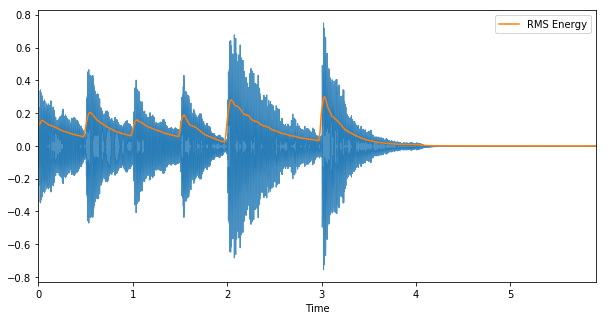

In [20]:
# 加载音频
audio_data, sr = librosa.load('attachment/mir01-music-example.wav', sr=None)
# 调用librosa中的rmse直接对音频每个长度为2048的帧进行计算得到均方根能量
rmse = librosa.feature.rms(y=audio_data, frame_length=2048, hop_length=512)
# 画出音频波形及均方根能量随时间的变化
plt.figure(figsize=(10,5))
librosa.display.waveshow(audio_data, sr=sr, alpha=0.8)
times = librosa.frames_to_time(np.arange(len(rmse.T)), sr=sr, hop_length=512)
plt.plot(times, rmse.T, label='RMS Energy')
plt.legend(loc='best')

另外一大常用的预处理就是将音频信号从时域变换为频域，主要用到的时频谱在MIR-01文章的最后一部分已有介绍过，这里主要提示下在变换过程中，容易混淆的一些概念与术语。

经过STFT得到的振幅谱其实是一个二维矩阵`D`，其中一维沿着时间，另一维沿着频率。首先“时间”并不用日常生活中的分秒来表示，画图显示频谱时会用分秒，但数据本身的时间轴是以“帧”即frame为单位，每一帧代表多少秒，是由原始音频的采样率`sr`，和对信号加窗后两窗之间的距离`hop_length`决定，因此一帧等于`hop_length/sr`所得的秒数。

每一帧下的频谱，频率的分辨率由`sr`以及DFT或FFT的窗长`n_fft`决定，因此每一个频点frequency bin覆盖了`sr/n_fft`范围的频率。

在指定frame（假设为`t`）与frequency bin（假设为`f`）对应的矩阵位置上即`D[f,t]`，由于经过傅里叶变换的原因，其值是一个复数，由此可得该点振幅magnitude为`numpy.abs(D[f,t])`，而相位则为`numpy.angle(D[f, t]) `。将振幅谱D上的所有值做平方即`D**2`，我们就得到了功率谱。无论是振幅谱(amplitude spectrogram)还是功率谱(power spectrogram)，都可以对矩阵上的值取对数转换为以dB为单位的值，此时可称频谱为对数谱log-spectrogram。

注意不要混淆的是，沿着频率轴也经常进行对数操作(log-frequency scale)以得到梅尔频谱，这样得到的梅尔频率标度拟合了人耳对频率的感知度。此外，Bark scale是更加贴切人耳对频率感知的标度，但它对频率并不采取对数操作。

其他预处理涉及到滤波和专用模型的运用，博主还是后续文章中就着具体例子具体介绍吧`_(:3 」∠ )_`